### Assignment 3

#### Submit your assignment as .ipynb

#### Exercise 1.

A quanto option (http://en.wikipedia.org/wiki/Quanto), unlike a normal European option that pays the final payoff in the denominated currency of the underlying stock or asset,
it pays the final payoff in another currency at a pre-determined exchange rate.
For example, a stock $S_a$ is listed on Singapore Exchange (SGX) and denominatd in SGD.
A quanto call option allows the holder to receive the payoff $\max(S_a-K, 0)$ in another currency (called the quanto currency), e.g., JPY,  at a pre-fixed exchange rate $F_0 = 80$.
The payoff of the quanto call option in the stock's denominatd currency is thus
$F_0 \times \max(S_a(T)-K, 0) \times S_b(T)$ where $S_b$ is the value of one quanto currency in the unit of the stock's denominated currency.

Assuming the stock and the quanto-denominated currency pair both follow geometric Brownian motion:
\begin{align}
& dS_a(t) / S_a(t) = (r_d - r_a) dt + \sigma_a dW_a \\
& dS_b(t) / S_b(t) = (r_d - r_b) dt + \sigma_b dW_b \\
& dW_a dW_b = \rho dt
\end{align}

where $r_d$ is the risk free interest rate of the stock's denominated currency,
$r_a$ is the continuous yield of the stock,
and $r_b$ is the interest rate of the quanto currency,
and $\rho \in [-1, 1]$ is the correlation between the stock price and the foreign exchange rate.

Prove that the closed form solution for a quanto European call option is:
\begin{align}
S_b(0) F e^{-r_bT}\left( S_a(0) e^{(r_d - r_a + \rho \sigma_a \sigma_b)T} N(d_+) - K N(d_-)  \right).
\end{align}
where
\begin{align*}
d_{\pm} = \frac{\ln \frac{S_a(0)}{K} + (r_d - r_a + \rho \sigma_a \sigma_b \pm \frac{1}{2}\sigma_a^2)T}{\sigma_a \sqrt{T}}
\end{align*}

Implement an function to price a quanto European call option in closed form:

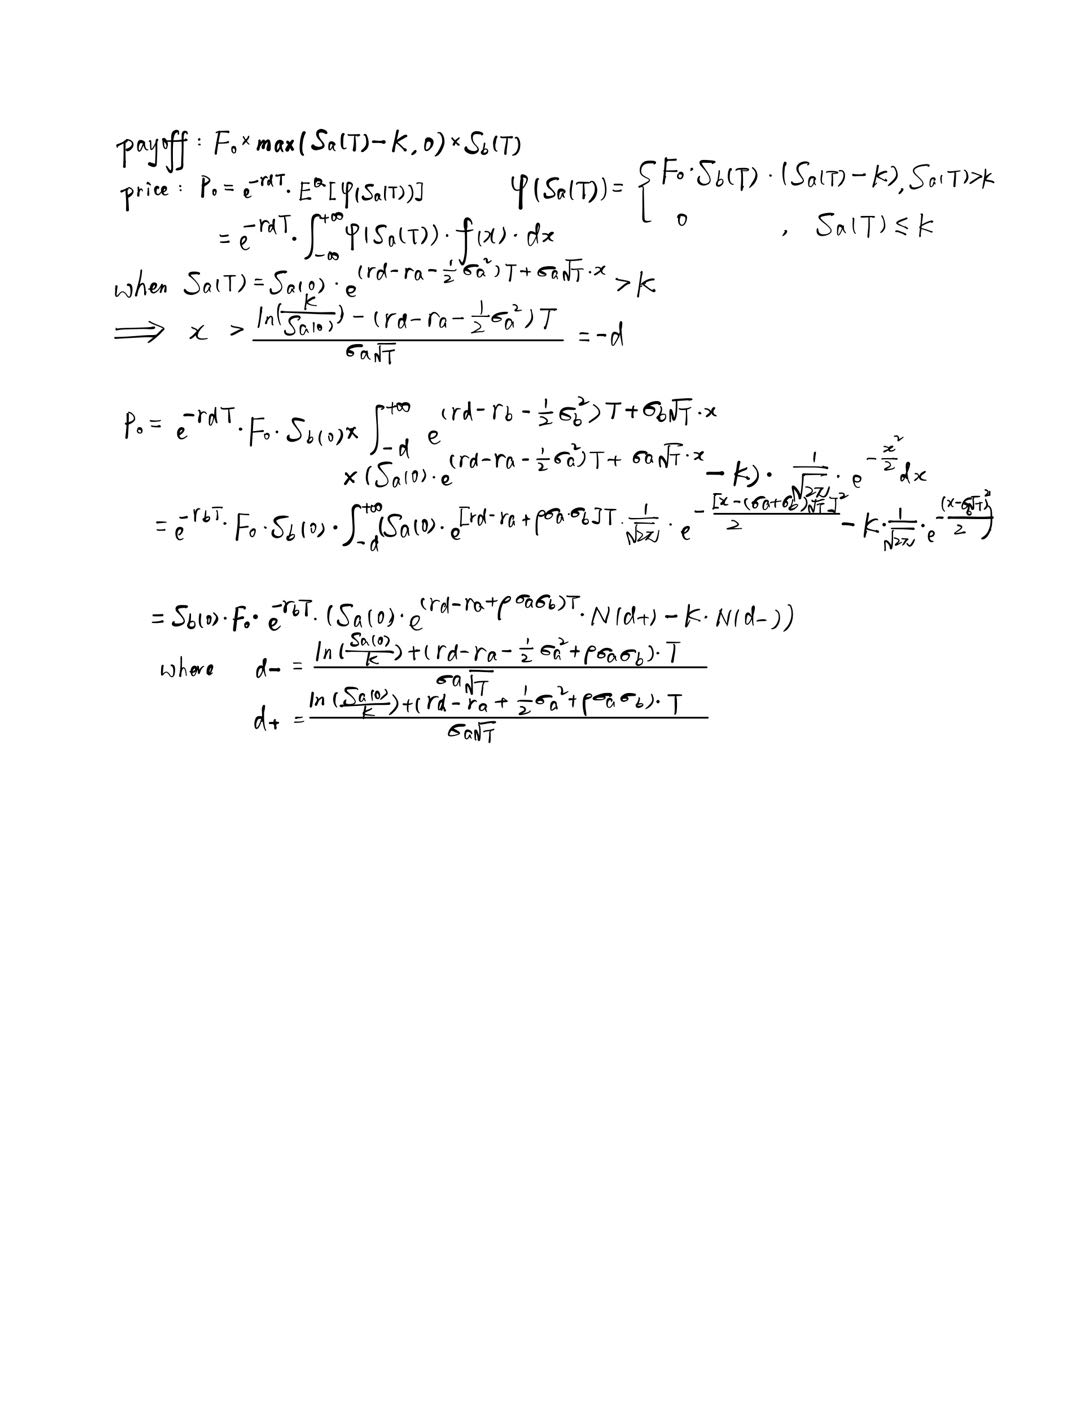

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math

In [3]:
def cnorm(x):
    return (1.0 + math.erf(x / math.sqrt(2.0))) / 2.0

def quantoCallAnalytic(rd, ra, rb, sigmaA, sigmaB, rho, s_a0, s_b0, T, K, F0):
    x = (np.log(K/s_a0)-(rd-ra-0.5*sigmaA*sigmaA))/(sigmaA*np.sqrt(T))
    d1=(np.log(s_a0/K)+(rd-ra+rho*sigmaA*sigmaB-0.5*sigmaA*sigmaA)*T)/(sigmaA*np.sqrt(T))
    d2=(np.log(s_a0/K)+(rd-ra+rho*sigmaA*sigmaB+0.5*sigmaA*sigmaA)*T)/(sigmaA*np.sqrt(T))
    if x >= (np.log(K/s_a0)-(rd-ra-0.5*sigmaA*sigmaA)*T)/sigmaA*np.sqrt(T):
        return s_b0*F0*np.exp(-rb*T)*(s_a0*np.exp((rd-ra+rho*sigmaA*sigmaB)*T)*cnorm(d2)-K*cnorm(d1))
    else:
        return 0

Price a call option with

In [4]:
s_a0=100 
s_b0 = 1/80
T=1
K=102
F0=80
rd=0.02
ra=0.05
rb=0.01
sigmaA =0.15
sigmaB =0.1
rho=0.35
price = quantoCallAnalytic(rd, ra, rb, sigmaA, sigmaB, rho, s_a0, s_b0, T, K, F0)
print("the price of the call option is:",price)

the price of the call option is: 3.963754119681889


Plot the change of price with respect to the change of correlation.
Include in the submission the derivation of the closed form formula, the implementation of the function, and test results.

<function matplotlib.pyplot.show(close=None, block=None)>

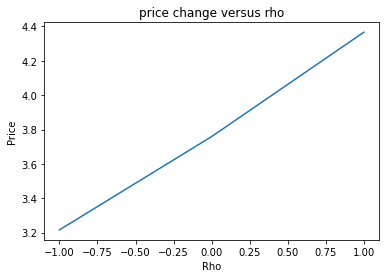

In [5]:
y = [quantoCallAnalytic(rd, ra, rb, sigmaA, sigmaB, x, s_a0, s_b0, T, K, F0) for x in range(-1, 2)]
plt.plot(range(-1, 2), y)
plt.xlabel('Rho')
plt.ylabel('Price')
plt.title('price change versus rho')
plt.show

#### Exercise 2.

Implement a Monte Carlo pricer to price the quanto call option in the stock's denominated currency

In [6]:
import math
from numpy.random import random 
import numpy as np
def quantoCallOptionMC(rd, ra, rb, sigmaA, sigmaB, rho, s_a0, s_b0, T, K, F0, nPath):
    np.random.seed(0)
    sum,C=0,np.identity(2) 
    C[0,1] = C[1,0] = rho
    L=np.linalg.cholesky(C)
    for i in range(nPath):
        brownians = np.zeros((2,1))
        dt = T
        stdev = math.sqrt(dt)
        for j in range(2):
            brownians[j] =  np.random.normal(0,stdev,1) 
        brownians    =  np.matmul(L,brownians)
        x1,x2    =  math.log(s_a0),math.log(s_b0)
        a = (rd-ra-0.5*sigmaA*sigmaA)*dt
        b = brownians[0,0] * sigmaA
        x1 += a + b
        a = (rd-rb-0.5*sigmaB*sigmaB)*dt
        b = brownians[1,0] * sigmaB
        x2 += a + b
        h = max(math.exp(x1)-K,0)*math.exp(x2)*F0
        sum += h
    pv = math.exp(-rd * T)*sum/nPath
    return pv

The Monte Carlo price should simulate $S_a$ and $S_b$.
Compare the result with the closed form solution. Plot the convergence chart for different number of simulation paths.



<function matplotlib.pyplot.show(close=None, block=None)>

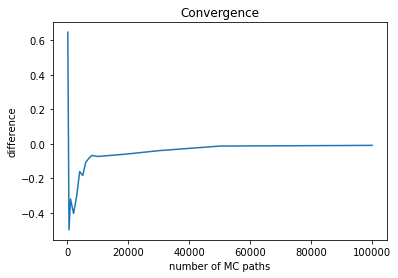

In [7]:
j=[100,500,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,20000,30000,50000,100000]
pricediff = [(quantoCallOptionMC(rd, ra, rb, sigmaA, sigmaB, rho, s_a0, s_b0, T, K, F0, x)-price) for x in j]
plt.plot(j, pricediff)
plt.xlabel('number of MC paths')
plt.ylabel('difference')
plt.title('Convergence')
plt.show

#### Exercise 3.

Implement a Monte-Carlo pricer that prices quanto arithmetic Asian call option.
A quanto arithmetic Asian call option pays the option holder $F_0 \times \max(A - K, 0)$ on the settlement date $t_s$ in the quanto currency, where

\begin{align}
A = \frac{1}{n}\sum_{i=1}^n S_a(t_i).
\end{align}

where $t_1 < t_2 < \ldots < t_n \leq t_s$. Equivalently, the payoff in the underlying's denominated currency is $F \times \max(A - K, 0) \times S_b(t_s)$, where $S_b$ is the value of one quanto currency in the unit of underlying's denominated currency.

Design the signature of the pricer, explain the main difference from the implementation in exercise 2.
Conduct test cases that demonstrate the correctness of the implementation (e.g., for degenerate case with only 1 fixing, the closed form solution exists and the price converges).


In [8]:
def quantoASCallOptionMC(rd, ra, rb, sigmaA, sigmaB, rho, s_a0, s_b0, T, K, F0, nPath,nT):
    np.random.seed(0)
    sum,C=0,np.identity(2) 
    C[0,1] = C[1,0] = rho
    L=np.linalg.cholesky(C)
    for i in range(nPath):
        brownians = np.zeros((2,nT))
        dt = T/nT
        stdev = math.sqrt(dt)
        for j in range(2):
            brownians[j] =  np.random.normal(0,stdev,nT) 
        brownians    =  np.matmul(L,brownians)
        x1,x2    =  math.log(s_a0),math.log(s_b0)
        xa=np.zeros(nT)
        for j in range(nT):
            a = (rd-ra-0.5*sigmaA*sigmaA)*dt
            b = brownians[0,j] * sigmaA
            x1 += a + b
            xa[j]=math.exp(x1)
            a = (rd-rb-0.5*sigmaB*sigmaB)*dt
            b = brownians[1,j] * sigmaB
            x2 += a + b
        h = max(np.mean(xa)-K,0)*math.exp(x2)*F0
        sum += h
    pv = math.exp(-rd * T)*sum/nPath
    return pv

The main differences between the exercise 2 and 3: 
First, degenerate case is 1 in exercise 2 but nT in 3 exercise 3.
Second, the payoffs of the two exercises are different.

In [11]:
x = quantoASCallOptionMC(rd, ra, rb, sigmaA, sigmaB, rho, s_a0, s_b0, T, K, F0, 10000,1)
y = quantoCallOptionMC(rd, ra, rb, sigmaA, sigmaB, rho, s_a0, s_b0, T, K, F0, 10000)
diff = x - y
diff

0.0

#### Exercise 4.

On 21 Apr 2020, WTI Crude Oil May 2020 contract collapsed to negative for the first time.
This posed challenges to clearing houses\footnote{The Chicago Mercantile Exchange announced to switch to its pricing and margining options model from Black-Scholes to a normal vol Bachelier model if oil contract price is close to 0 (\url{https://www.cmegroup.com/content/dam/cmegroup/notices/clearing/2020/04/Chadv20-152.pdf}).} to calcualte settlement and margin for option contracts, and to financial institues to risk manage their positions.
One way to represent possible negative prices is to use a shifted log-normal model (not necessarily realisic and easy to risk manage):
\begin{align}
    \frac{dS_t}{(S_t+A)} = rdt + \sigma dW_t
\end{align}

where $A$ is a constant. In the context of crude oil futures, $A$ could represent the cost of delivery and storage (note also that commodity underlyings are normally not modelled as spot process, since Futures and Forwards are much more liquid than spot, here we are making simplifications again).

Implement a MC pricer to use the shifted log-normal model to price European payoffs.

In [16]:
from enum import Enum
class PayoffType(str, Enum):
    Call = 'Call'
    Put = 'Put'
class EuropeanOption():
    def __init__(self, expiry, strike, payoffType):
        self.expiry = expiry
        self.strike = K
        self.payoffType = payoffType
    def payoff(self, S):
        if self.payoffType == PayoffType.Call:
            return max(S - self.strike, 0)
        elif self.payoffType == PayoffType.Put:
            return max(self.strike - S, 0)
        
def mcShiftedLogN(payoff, nPaths, S0, shift, T,r, sigma):
# payoff - the European payoff function
# shift - the shift A
# T - time to maturity
# r - risk-free interest rate
# sigma - the volatility
    payoff = EuropeanOption(T, K, PayoffType.Put)
    np.random.seed(0)
    sum = 0
    stdev = np.math.sqrt(T)
    for i in range(nPaths):
        wT = np.random.normal(0,stdev)
        S=(S0+shift)*math.exp((r-0.5*sigma*sigma)*T+sigma*wT)-shift
        h = EuropeanOption.payoff(payoff,S)
        sum += h
    pv = math.exp(-r*T)* sum/nPaths
    return pv

Describe your state variable and the step-wise induction formula using Euler discretization scheme.
Price an put option with $S_0 = -10, T=1, \sigma=150\%, r = -1\%, and\ K = -15$, for the shift A ranging from 15 to 100.



<function matplotlib.pyplot.show(close=None, block=None)>

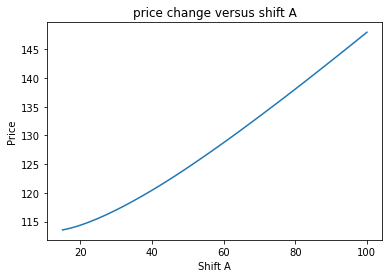

In [17]:
S0=-10
T=1
sigma=1.5
r=-0.01
payoff = EuropeanOption(T, -15, PayoffType.Put)
y = [mcShiftedLogN(payoff, 10000, S0, shift, T,r, sigma) for shift in range(15, 101)]
plt.plot(range(15, 101), y)
plt.xlabel('Shift A')
plt.ylabel('Price')
plt.title('price change versus shift A')
plt.show